In [ ]:
import os
import sys
import socket
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
np.random.seed(42)
import matplotlib.patches as mpatches
import os
import sys
import socket
import pandas as pd
import matplotlib.path as mpath

import numpy as np
from functions import generate_xy_grid
from trends_and_climatology_functions import get_monthly_observations, plot_monthly_boxplots,  load_dict_list, plot_monthly_barplots, plot_double_hist_map, create_region_path, plot_hist_map, get_dict_list_for_labels, extract_result_dict, extract_n_obs_per_day_xarray, extract_result_dict_same_grid, extract_result_dict_xarray, calculate_daily_coverage_for_months, mk_test_for_months, theil_sen_multi_season, extract_merra_dict_list, load_dict_list, get_closest_indices
import xarray as xr
import cartopy.crs as ccrs
from pyproj import Proj, transform
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
import numpy as np
plt.style.use("bmh")




In [ ]:
# Import dict_list containing model data for the given years and model run 
bands=[31]
nK = 7
patch_threshold = 15
merra_folder = "/MERRA/"
data_loc = "data_loc_of_dict_lists"

cao_labels = [3,6] #[4]
years = [yr for yr in range(2000, 2026)]
band_str = str(bands[0])#"31" 
model_run_name = f"dnb_ice01_l95_z50_ps128_band{band_str}"
dict_ext_model_run_name = f"dnb_ice01_l95_z50_ps128_band{band_str}"

dict_list, time_periods = load_dict_list(years,
                            data_loc,
                            model_run_name,
                            dict_ext_model_run_name,
                            cao_threshold=0,
                            patch_threshold=patch_threshold,
                            last_filter=128,
                            nK=nK,
                            stride=64,
                            addon="_res100", # optional see function for details regarding load names
                            labels = cao_labels)
print(len(dict_list))
dates_model = [item["date"] for item in dict_list]
dates_model = np.unique(dates_model)#.shape
# dates_model = dates_model[:-7]

In [3]:
# Generate lons and lats for chosen resolution and get closest indices for each pixel for merra and model
resolution_km = 100#128
# example merra file for extration of lon and lat
lon_merra = xr.open_dataset(f"{merra_folder}/2020/MERRA2_400.tavg1_2d_slv_Nx.20200829.SUB.nc").lon.values
lat_merra = xr.open_dataset(f"{merra_folder}/2020/MERRA2_400.tavg1_2d_slv_Nx.20200829.SUB.nc").lat.values

lon_mesh_merra, lat_mesh_merra = np.meshgrid(lon_merra, lat_merra)

projection = ccrs.Stereographic(central_latitude=90)
x_grid_merra, y_grid_merra = lon_mesh_merra[:, :], lat_mesh_merra[:, :]

north_polar_stereo = Proj(proj='stere', lat_ts=70, lat_0=90, lon_0=0, k=1, x_0=0, y_0=0, datum='WGS84')
geographic = Proj(proj='latlong', datum='WGS84')

x_grid_coarse, y_grid_coarse = generate_xy_grid(x_extent=[-3e6, 2.2e6], y_extent=[-4e6, -0.5e6], grid_resolution=resolution_km*1e3)
x_grid_coarse, y_grid_coarse = transform(north_polar_stereo, geographic, x_grid_coarse, y_grid_coarse)

closest_indices_coarse, distances_closest_coarse = get_closest_indices(x_grid_coarse, y_grid_coarse, x_grid_coarse, y_grid_coarse) 
closest_indices_merra, distances_merra = get_closest_indices(x_grid_merra, y_grid_merra, x_grid_coarse, y_grid_coarse)


/tmp/ipykernel_1903935/605224061.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_grid_coarse, y_grid_coarse = transform(north_polar_stereo, geographic, x_grid_coarse, y_grid_coarse)


In [ ]:
M_threshold=0
T_pressure=850

merra_dict_list, merra_dates = extract_merra_dict_list(dates_model, merra_folder, M_threshold=M_threshold, T_pressure=T_pressure
)
result_dict_merra_xr = extract_result_dict_xarray(merra_dict_list, x_grid_coarse, y_grid_coarse, closest_indices_merra, distances_merra, first_date="20000301", last_date="20250228")



In [ ]:
M_threshold=3.75
T_pressure=850

merra_dict_list_best, merra_dates_best = extract_merra_dict_list(dates_model, merra_folder, M_threshold=M_threshold, T_pressure=T_pressure
)
result_dict_merra_xr_best = extract_result_dict_xarray(merra_dict_list_best, x_grid_coarse, y_grid_coarse, closest_indices_merra, distances_merra, first_date="20000301", last_date="20250228")

In [ ]:

dict_list = get_dict_list_for_labels(dict_list, cao_labels, nK)
result_dict_xr = extract_result_dict_xarray(dict_list, x_grid_coarse, y_grid_coarse, closest_indices_coarse, distances_closest_coarse, last_date="20250228", first_date="20000301", same_grid=True)


In [6]:
obs_mask = (~result_dict_xr.isnull()).mean(axis=0)*100#.plot(vmax=1)

x_grid_coarse_obs = np.where(obs_mask.values>=90, x_grid_coarse, np.nan)
y_grid_coarse_obs = np.where(obs_mask.values>=90, y_grid_coarse, np.nan)

x_grid_coarse_obs_wo = np.where(obs_mask.values>0, x_grid_coarse, np.nan)
y_grid_coarse_obs_wo = np.where(obs_mask.values>0, y_grid_coarse, np.nan)

sw = (x_grid_coarse_obs_wo>=-45) & (x_grid_coarse_obs_wo<-20) & (y_grid_coarse_obs_wo < 70) & (y_grid_coarse_obs_wo > 55)
region_sw = np.where(sw & np.isfinite(x_grid_coarse_obs))

se = (x_grid_coarse_obs_wo>=-20) & (y_grid_coarse_obs_wo < 65)  & (y_grid_coarse_obs_wo > 55)  & ~((x_grid_coarse_obs_wo>15) & (y_grid_coarse_obs_wo < 65))
region_se = np.where(se  & np.isfinite(x_grid_coarse_obs))

mid = ((x_grid_coarse_obs_wo >= -25) & (x_grid_coarse_obs_wo < -25) & (y_grid_coarse_obs_wo > 70) & (y_grid_coarse_obs_wo < 82)) |  ((x_grid_coarse_obs_wo >= -25) & (x_grid_coarse_obs_wo<25) & (y_grid_coarse_obs_wo >= 65) & (y_grid_coarse_obs_wo < 82)) & ~((y_grid_coarse_obs_wo <68) & (x_grid_coarse_obs_wo >20))
region_mid = np.where(mid  & np.isfinite(x_grid_coarse_obs))

bar = (x_grid_coarse_obs_wo>=25) & (y_grid_coarse_obs_wo >= 68) & (y_grid_coarse_obs_wo < 82) & (x_grid_coarse_obs_wo < 60)
region_bar = np.where(bar  & np.isfinite(x_grid_coarse_obs))


south = (x_grid_coarse_obs_wo>=-45) & (x_grid_coarse_obs_wo<-20) & (y_grid_coarse_obs_wo < 65) & (y_grid_coarse_obs_wo > 55) | se
region_south = np.where(south  & np.isfinite(x_grid_coarse_obs))

all_ = sw | se | mid | bar 
north = mid | bar 
region_north = np.where(north & np.isfinite(x_grid_coarse_obs))
region_all = np.where(all_ & np.isfinite(x_grid_coarse_obs))
# all_wo_thr = (x_grid_coarse_obs_wo>=-45) & (y_grid_coarse_obs_wo >= 55) & ~((x_grid_coarse_obs_wo>15) & (y_grid_coarse_obs_wo < 65)) & (y_grid_coarse_obs_wo < 82) & (x_grid_coarse_obs_wo < 60)
region_all_wo_thr = np.where(all_ & np.isfinite(x_grid_coarse_obs_wo))


In [7]:
# MASK OUTSIDE OF DOMAIN REGIONS 
xr_mask = np.zeros_like(x_grid_coarse, dtype=bool)
xr_mask = np.where(all_ & (obs_mask.values>=90), 1, 0)
result_dict_xr = result_dict_xr.where(xr_mask)#.isel(time=0).plot()#[0, region_all[0], region_all[1]]#.plot()
# result_dict_merra_xr_best = result_dict_merra_xr_best.where(xr_mask)
# result_dict_merra_xr = result_dict_merra_xr.where(xr_mask)


In [ ]:
result_dict_merra_xr_best.to_netcdf(merra_folder + f"cao_masks/merra_cao_mask_Tp{T_pressure}_Mthr{M_threshold}_{years[0]}-{years[-1]}.nc")
result_dict_merra_xr.to_netcdf(merra_folder + f"cao_masks/merra_cao_mask_Tp{T_pressure}_Mthr{M_threshold}_{years[0]}-{years[-1]}.nc")
result_dict_xr.to_netcdf(merra_folder + f"cao_masks/CAOnet_cao_mask_{years[0]}-{years[-1]}.nc")


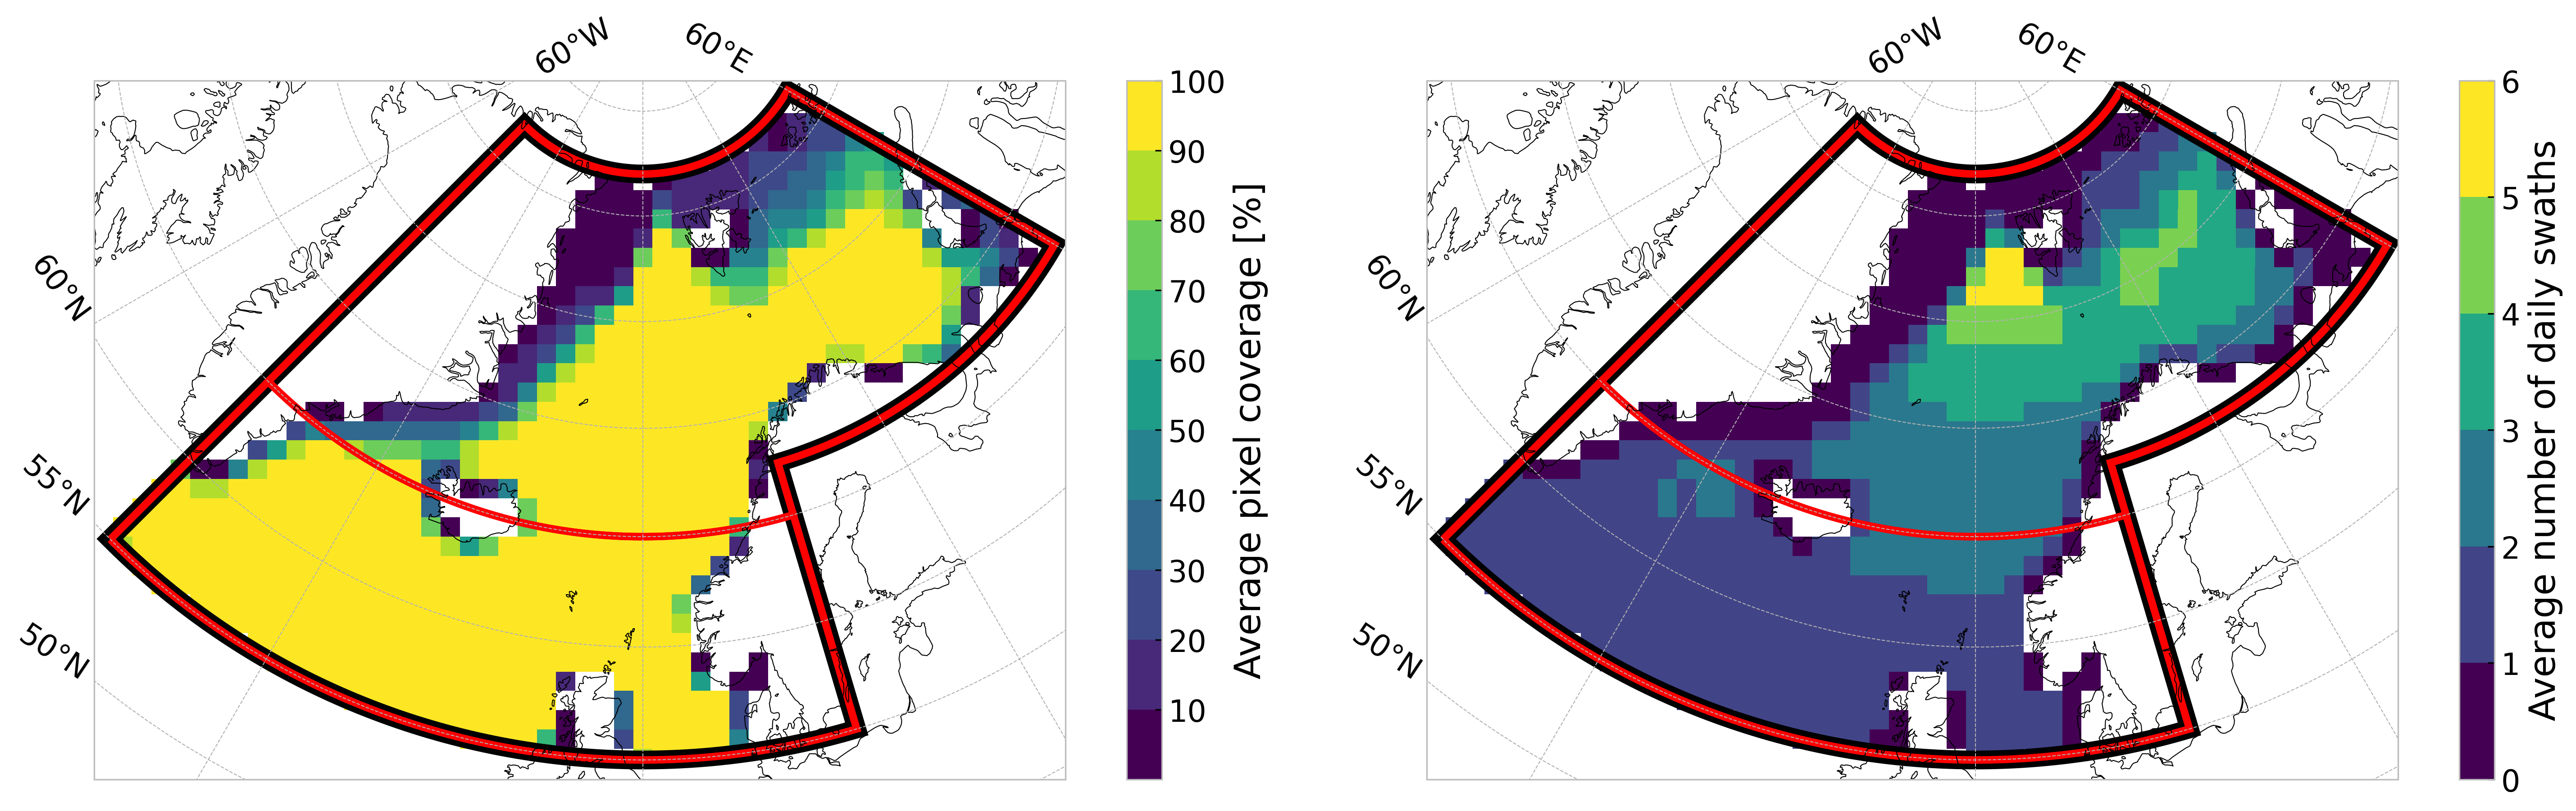

In [21]:
plt.style.use("bmh")
obs_per_day = extract_n_obs_per_day_xarray(dict_list, x_grid_coarse, y_grid_coarse, first_date="20000301", last_date="20291231")
obs_per_day_mean = obs_per_day.mean(axis=0)
extent = [-45, 33, 54, 85]

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(20, 6), dpi=300)
norm_100 = BoundaryNorm(boundaries=np.linspace(0, 100, 11), ncolors=256)
cb = axs[0].pcolormesh(obs_mask.lon, obs_mask.lat, obs_mask.where(all_ & np.isfinite(x_grid_coarse_obs_wo)), transform=ccrs.PlateCarree(), norm=norm_100)
plt.colorbar(cb, label="Average pixel coverage [%]", ticks=np.arange(10, 101, 10))
axs[0].coastlines()
gl = axs[0].gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.right_labels = False
gl.bottom_labels = False

axs[0].set_extent(extent, crs=ccrs.PlateCarree())


norm_8 = BoundaryNorm(boundaries=np.arange(7), ncolors=256)
cb = axs[1].pcolormesh(obs_per_day_mean.lon, obs_per_day_mean.lat, obs_per_day_mean.where(all_ & np.isfinite(x_grid_coarse_obs_wo)), transform=ccrs.PlateCarree(),  norm=norm_8)
plt.colorbar(cb, label="Average number of daily swaths")
axs[1].coastlines()
gl = axs[1].gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.right_labels = False
gl.bottom_labels = False

axs[1].set_extent(extent, crs=ccrs.PlateCarree())
axs[0].set_facecolor("white")
axs[1].set_facecolor("white")


vertex_coords = [
                [-45, 55],  # Bottom left corner
                [16.5, 55],  # Bottom right corner before the turn upward
                [16.5, 67.5],  # Top right corner after the turn upward
                [60, 67.5],  # Top right corner after the turn rightward
                [60, 82],  # Top right corner
                [-45, 82],  # Top left corner
                [-45.05, 55]  # Top left corner
                ]
vertices = np.array(vertex_coords)

# Interpolate points along the edges of the polygon for smooth transition
num_pts = 100
lons = np.concatenate([
    np.linspace(vertices[i, 0], vertices[i+1, 0], num_pts)
    for i in range(vertices.shape[0] - 1)
])
lats = np.concatenate([
    np.linspace(vertices[i, 1], vertices[i+1, 1], num_pts)
    for i in range(vertices.shape[0] - 1)
])

# Close the polygon loop by appending the first vertex at the end
lons = np.append(lons, vertices[0, 0])
lats = np.append(lats, vertices[0, 1])

# Create a path of the "rectangle"
path = mpath.Path(np.vstack((lons, lats)).T)

# Create a patch from the path
patch = matplotlib.patches.PathPatch(path, facecolor='none',
                                    edgecolor='black', linewidth=10, transform=ccrs.PlateCarree())

# Add the patch to the Axes

axs[1].add_patch(patch)
patch = matplotlib.patches.PathPatch(path, facecolor='none',
                                    edgecolor='black', linewidth=10, transform=ccrs.PlateCarree())
axs[0].add_patch(patch)


regions = {
    "south": np.array([[-45, 55], [16.5, 55], [16.5, 65], [-20, 65], [-20, 65], [-45, 65]]),
    "nor": np.array([[-45, 70], [-45, 65], [16.5, 65], [16.5, 67.5], [60, 67.5], [60, 82], [-45, 82]]),
}


# Plot paths for all subregions
for region_key, region_vertices in regions.items():
    create_region_path(axs[0], region_vertices)

for region_key, region_vertices in regions.items():
    create_region_path(axs[1], region_vertices)

fig.tight_layout()
plt.show()